In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_data(rating_pth, link_pth=None, sep=' '):
    """
    从文件中读取数据
    :param sep: 分隔符
    :type sep: str
    :param rating_pth: rating文件地址
    :type rating_pth: str
    :param link_pth: link文件地址
    :type link_pth: str
    :return: rating_df, link_df
    :rtype: DataFrame, DataFrame
    """
    rating_names = ['user', 'item', 'rating']
    rating_dtype = {
        'user': int,
        'item': int,
        'rating': float,
    }
    rating_df = pd.read_csv(
        rating_pth,
        skiprows=1,
        header=None,
        sep=sep,
        names=rating_names,
    )
    # 读取的时候会把最后一个空行读进来
    rating_df.drop(rating_df.tail(1).index, inplace=True)
    rating_df['user'] = rating_df['user'].astype(int)
    rating_df['item'] = rating_df['item'].astype(int)
    # 确保没有空缺值
    assert rating_df.isnull().any().sum() == 0

    if link_pth is not None:
        link_names = ['user1', 'user2', 'weight']
        link_dtype = {
            'user1': int,
            'user2': int,
            'weight': float,
        }
        link_df = pd.read_csv(
            link_pth,
            skiprows=1,
            header=None,
            sep=sep,
            names=link_names,
        )
        # 都进来发现index全部是nan，需要处理一下
        link_df = link_df.reset_index().drop(columns='index')
        # 去掉尾空行
        link_df.drop(link_df.tail(1).index, inplace=True)
        # 确保没有空缺值
        link_df['user1'] = link_df['user1'].astype(int)
        link_df['user2'] = link_df['user2'].astype(int)

        assert link_df.isnull().any().sum() == 0
        return rating_df, link_df
    else:
        return rating_df

In [23]:
def filter_data(rating_df_filter, link_df_filter):
    """
    对数据集进行迭代过滤
    保证：
        1. rating数据中的user和link数据中的user1集合完全一致
        2. rating中的user和item出现次数不少于4次，link中的user1不少于4次
    :param link_df_filter: 社交关系表，每条信息是[user1, user2, weight]，weight=0/1
    :type link_df_filter: DataFrame
    :param rating_df_filter: 评分表，每条信息是[user, item, rating]，rating=1-5
    :type rating_df_filter: DataFrame
    :return: link_df_filter, rating_df_filter, n
    :rtype: DataFrame, DataFrame, int
    """
    # 记录迭代次数
    n = 0

    """
    while条件的意思分别是：
    (~link_df_filter.user1.isin(rating_df_filter.user)).sum() link.user1中不在rating.user中的数量
    (~rating_df_filter.user.isin(link_df_filter.user1)).sum() rating.user中不在link.user1中的数量
    (link_df_filter['user1'].value_counts() < 4).sum() link.user1中出现少于4次的数量
    (link_df_filter['user2'].value_counts() < 4).sum() link.user2中出现少于4次的数量
    (rating_df_filter['user'].value_counts() < 4).sum() rating.user中出现少于4次的数量
    (rating_df_filter['item'].value_counts() < 4).sum() rating.item中出现少于4次的数量
    """
    while ((~link_df_filter.user1.isin(rating_df_filter.user)).sum() >= 1) or \
        ((~rating_df_filter.user.isin(link_df_filter.user1)).sum() >= 1) or \
        ((link_df_filter['user1'].value_counts() < 4).sum() >= 1) or \
        ((link_df_filter['user2'].value_counts() < 4).sum() >= 1) or \
        ((rating_df_filter['user'].value_counts() < 4).sum() >= 1) or \
        ((rating_df_filter['item'].value_counts() < 4).sum() >= 1):

        # 将link中user1，user2出现少于四次的过滤掉
        link_df_filter = link_df_filter[link_df_filter.groupby('user1').user1.transform('count') >= 4]
        link_df_filter = link_df_filter[link_df_filter.groupby('user2').user2.transform('count') >= 4]
        # 将rating中只出现在rating.user中，但是没有出现在link.user1中的过滤掉
        rating_df_filter = rating_df_filter[rating_df_filter.user.isin(link_df_filter.user1)]
        # 将rating中user，item出现少于四次的过滤掉
        rating_df_filter = rating_df_filter[rating_df_filter.groupby('user').user.transform('count') >= 4]
        rating_df_filter = rating_df_filter[rating_df_filter.groupby('item').item.transform('count') >= 4]
        # 将link中只出现在link.user1中，但是没有出现在rating.user中的过滤掉
        link_df_filter = link_df_filter[link_df_filter.user1.isin(rating_df_filter.user)]

        n += 1
        if n > 100:
            break
    return rating_df_filter, link_df_filter, n

In [18]:
def draw_hist_pic(data_df: pd.DataFrame, title):
    fig = plt.figure(figsize=(15, 10))
    # plt.title(title)
    for i, key in enumerate(data_df.columns):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.hist(data_df[key])
        ax.set_title(key)
        ax.set_xlabel('idx')
        ax.set_ylabel('count')

    plt.show()

In [6]:
rating_df, link_df = read_data('../dataset/ratings_data.txt', '../dataset/trust_data.txt')

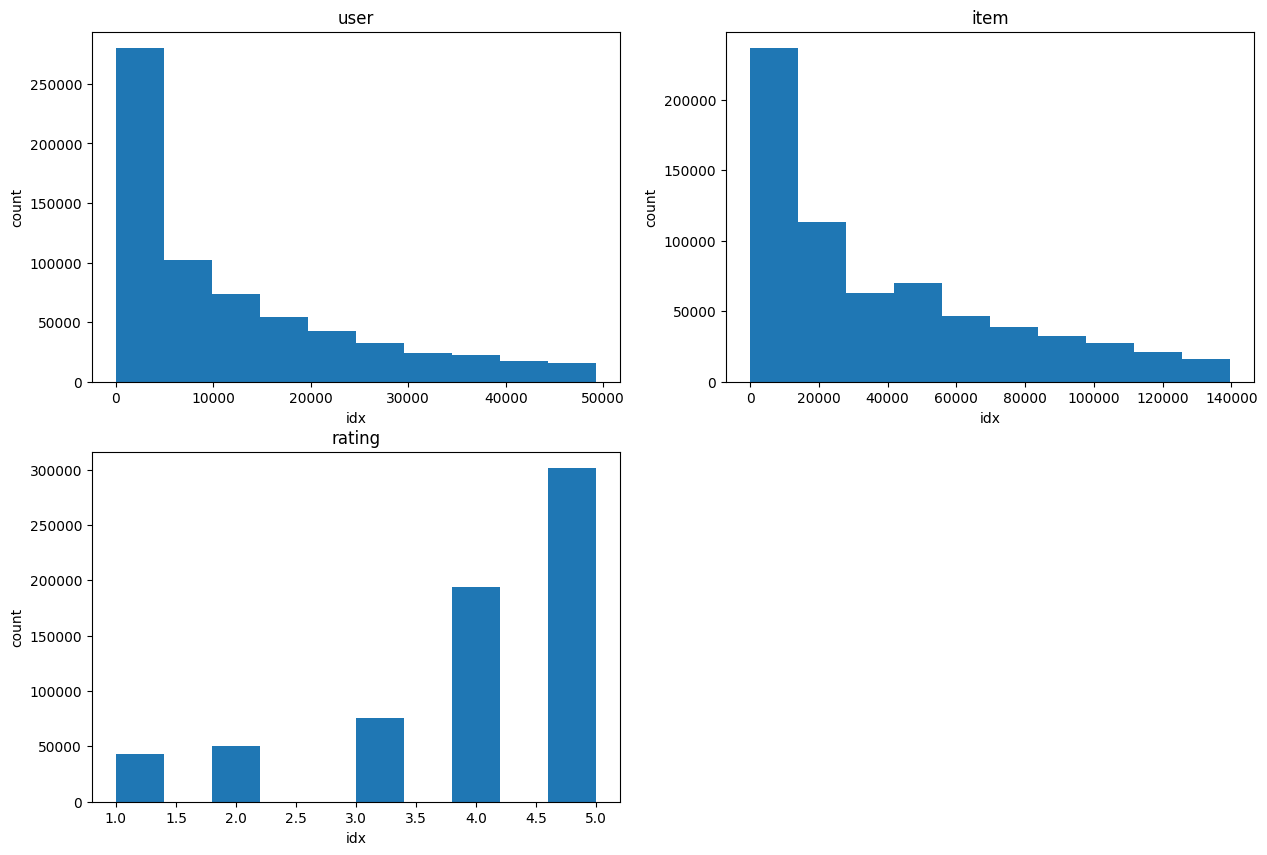

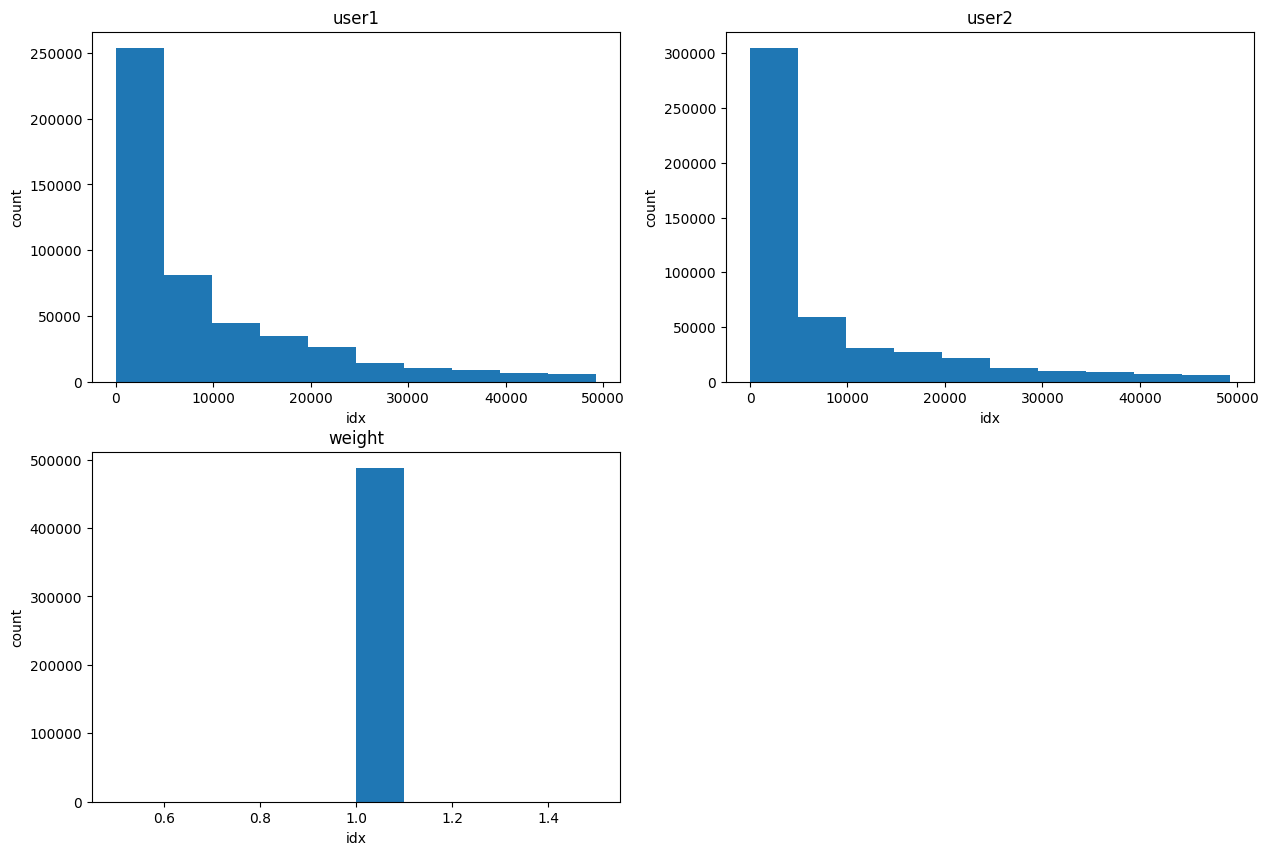

In [19]:
draw_hist_pic(rating_df, 'rating_raw')
draw_hist_pic(link_df, 'link_raw')

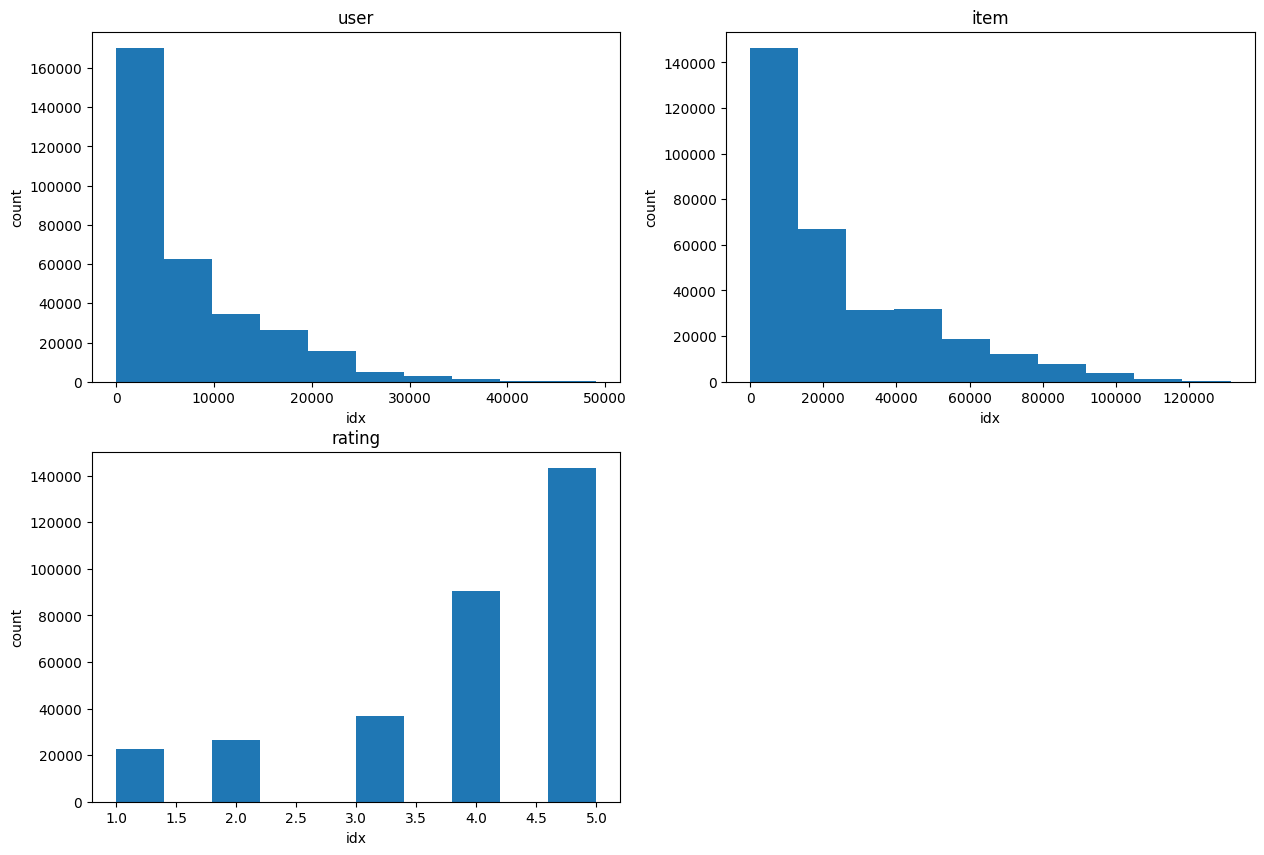

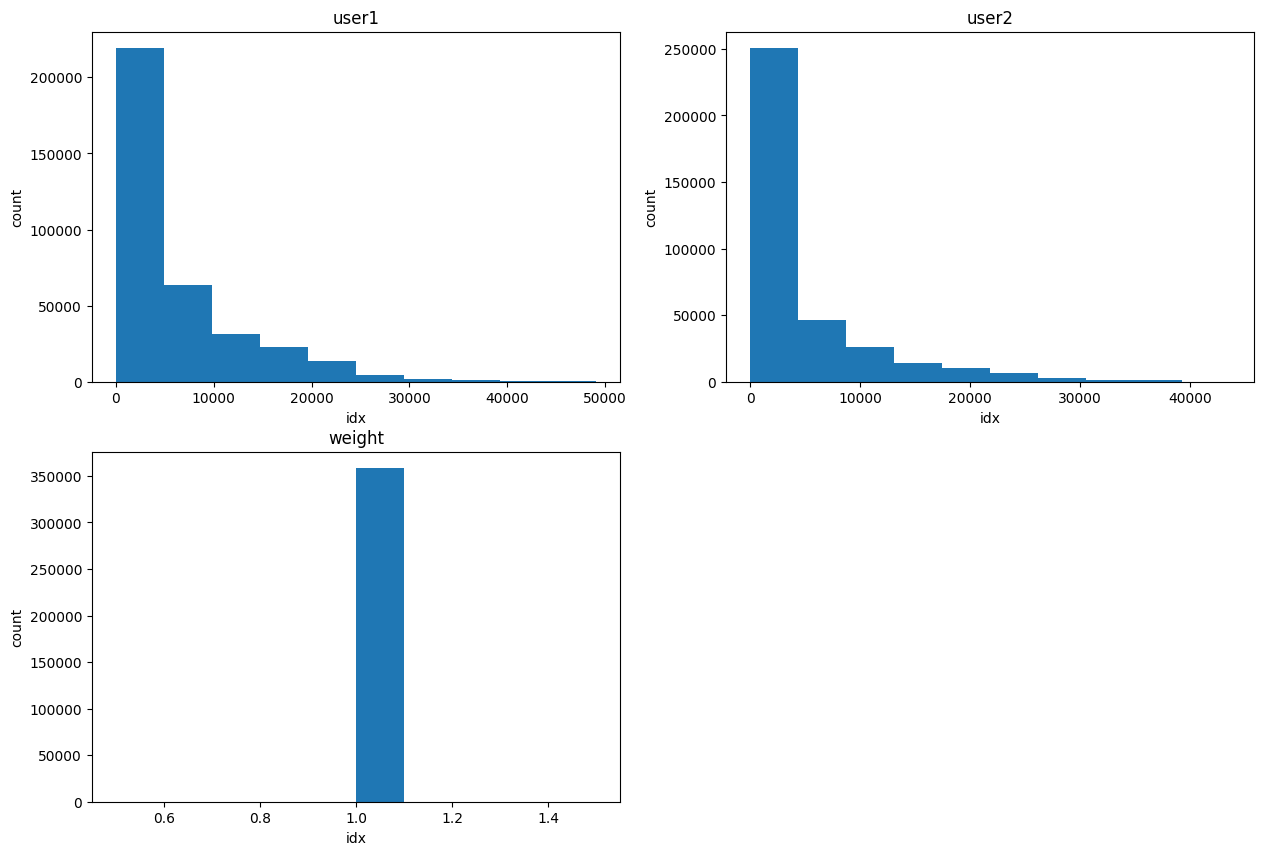

In [24]:
rating_df, link_df, _ = filter_data(rating_df, link_df)
draw_hist_pic(rating_df, 'rating_new')
draw_hist_pic(link_df, 'link_new')

In [29]:
print(f'user cnts: {rating_df["user"].nunique()}')
print(f'item cnts: {rating_df["item"].nunique()}')
print(f'user1 cnts: {link_df["user1"].nunique()}')
print(f'user2 cnts: {link_df["user2"].nunique()}')
print(f'edges in rating data: {len(rating_df)}')
print(f'edges in link data: {len(link_df)}')

user cnts: 10946
item cnts: 21412
user1 cnts: 10946
user2 cnts: 11188
edges in rating data: 319632
edges in link data: 358112


In [30]:
rating_df['rating'].describe()

count    319632.000000
mean          3.954322
std           1.236876
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [31]:
rating_df.to_csv('./data/rating_data.csv', index=False, header=True)

In [32]:
link_df.to_csv('./data/link_data.csv', index=False, header=True)